In [8]:

import os, sys
from matplotlib import pyplot as plt
import dataclasses
from typing import Optional

sys.path.append(os.path.join(os.getcwd(), "..", "..", "simulator"))
from utils import Dataset, load_req_result_list, ReqResult

@dataclasses.dataclass
class Backend:
    name: str
    label: str
    color: str
    num_gpus: int
    marker: str = "o"

# EXP_RESULT_ROOT="/workspace/exp-results"
EXP_RESULT_ROOT="/tmp/exp-results"

def load_result(model: str, dataset: str, backend: Backend, per_gpu_num_prompt: int, per_gpu_request_rate: float) -> list[ReqResult]:
    if '/' in model:
        model = model[model.rfind('/')+1:]
    path = f"{EXP_RESULT_ROOT}/{model}-{dataset}/{backend.name}-{per_gpu_num_prompt*backend.num_gpus}-{per_gpu_request_rate*backend.num_gpus}.exp"
    return load_req_result_list(path)

def get_attainment(results: list[ReqResult], ttft_slo_ms: Optional[float], tpot_slo_ms: Optional[float]):
    if ttft_slo_ms is None: ttft_slo_ms = 1e10
    if tpot_slo_ms is None: tpot_slo_ms = 1e10
    counter = 0
    for result in results:
        if result.ttft_ms <= ttft_slo_ms and result.tpot_ms <= tpot_slo_ms:
            counter += 1
    return counter / len(results)


[0.9633333333333334, 0.9433333333333334, 0.9066666666666666, 0.7466666666666667, 0.5466666666666666, 0.46, 0.3566666666666667]
[0.96, 0.94, 0.9, 0.73, 0.57, 0.44666666666666666, 0.39666666666666667]
[0.96, 0.94, 0.9, 0.73, 0.57, 0.44666666666666666, 0.39666666666666667]


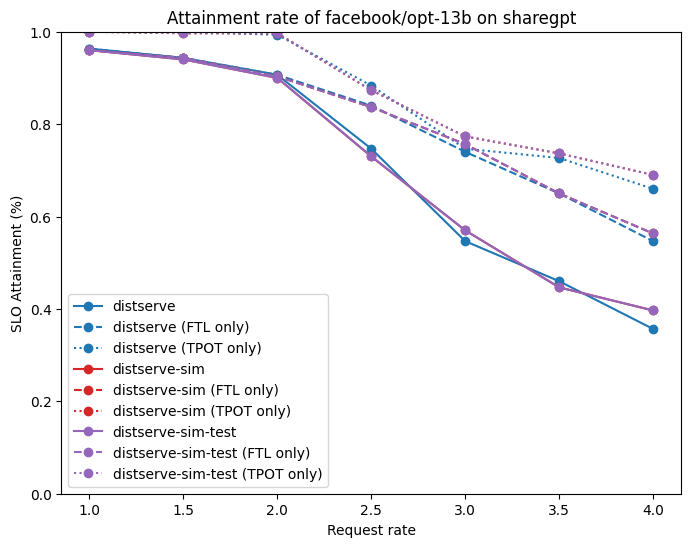

In [32]:
def draw_attainment_rate_plot(
    ax: plt.Axes,
    model: str,
    dataset: str,
    per_gpu_num_prompt_req_rates: list[(int, float)],
    backends: list[Backend],
    ttft_slo_ms: float,
    tpot_slo_ms: float
):
    ax.set_title(f"Attainment rate of {model} on {dataset}")
    ax.set_xlabel("Request rate")
    ax.set_ylabel("SLO Attainment (%)")

    for backend in backends:
        xs = [rate for _, rate in per_gpu_num_prompt_req_rates]
        ys_both = []
        ys_ttft = []
        ys_tpot = []
        for per_gpu_num_prompt, per_gpu_request_rate in per_gpu_num_prompt_req_rates:
            results = load_result(model, dataset, backend, per_gpu_num_prompt, per_gpu_request_rate)
            ys_both.append(get_attainment(results, ttft_slo_ms, tpot_slo_ms))
            ys_ttft.append(get_attainment(results, ttft_slo_ms, None))
            ys_tpot.append(get_attainment(results, None, tpot_slo_ms))
        ax.plot(xs, ys_both, label=backend.label, color=backend.color, marker=backend.marker)
        ax.plot(xs, ys_ttft, label=backend.label+" (FTL only)", linestyle="--", color=backend.color, marker=backend.marker)
        ax.plot(xs, ys_tpot, label=backend.label+" (TPOT only)", linestyle=":", color=backend.color, marker=backend.marker)
        print(ys_both)

    ax.legend()
    ax.set_ylim(0, 1)

fig, ax = plt.subplots(figsize=(8, 6))
draw_attainment_rate_plot(
    ax,
    "facebook/opt-13b",
    "sharegpt",
    # [(100, 1), (150, 1.5), (100, 2), (250, 2.5)],
    [(100, 1), (100, 1.5), (100, 2), (100, 2.5), (100, 3), (100, 3.5), (100, 4)],
    [
        Backend("distserve-c21d11", "distserve", "C0", 3),
        Backend("distserve-sim", "distserve-sim", "C3", 3),
        # Backend("vllm", "vllm", "C1", 1)
    ],
    200,
    100,
)
plt.show()